In [ ]:
#| hide
!pip install -Uqq nixtla
!pip install shap

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# SHAP Values

SHAP (SHapley Additive exPlanation) values use game theory to explain the output of any machine learning models. It allows us to explore in detail how exogenous features impact the final forecast, both at a single forecast step or over the entire horizon. 

When you forecast with exogenous features, you can access the SHAP values for all series at each prediction step, and use the popular [shap](https://shap.readthedocs.io/en/latest/) Python package to make different plots and explain the impact of the features.

This tutorial assumes knowledge on forecasting with exogenous features, so make sure to read our tutorial on [exogenous variables](https://docs.nixtla.io/docs/tutorials-exogenous_variables). Also, the `shap` package must be installed separately as it is not a dependency of `nixtla`.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/21_shap_values')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/21_shap_values.ipynb)

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

Let's see an example on predicting day-ahead electricity prices. The following dataset contains the hourly electricity price (`y` column) for five markets in Europe and US, identified by the `unique_id` column. The columns from `Exogenous1` to `day_6` are exogenous variables that TimeGPT will use to predict the prices.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df = df.query('unique_id == "NP"')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
5040,NP,2018-10-15 00:00:00,2.17,34078.0,1791.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5041,NP,2018-10-15 01:00:00,4.03,33469.0,1489.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5042,NP,2018-10-15 02:00:00,4.88,33313.0,1233.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5043,NP,2018-10-15 03:00:00,10.47,33535.0,1035.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5044,NP,2018-10-15 04:00:00,17.51,34267.0,854.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, `Exogenous1` holds information about the expected energy demand. `Exogenous2` is information about the expected energy production.

## 3. Forecasting electricity prices using exogenous variables

To produce forecasts we also have to add the future values of the exogenous variables. Let's read this dataset. In this case, we want to predict 24 steps ahead, therefore each `unique_id` will have 24 observations.

::: {.callout-important}
If you want to use exogenous variables when forecasting with TimeGPT, you need to have the future values of those exogenous variables too.
::: 

In [ ]:
future_ex_vars_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
future_ex_vars_df = future_ex_vars_df.query('unique_id == "NP"')
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
72,NP,2018-12-24 00:00:00,49119.0,461.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73,NP,2018-12-24 01:00:00,48115.0,484.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
74,NP,2018-12-24 02:00:00,47727.0,497.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75,NP,2018-12-24 03:00:00,47673.0,509.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
76,NP,2018-12-24 04:00:00,47848.0,510.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's call the `forecast` method, adding this information. To access the SHAP values, we also need to specify `feature_contributions=True` in the `forecast` method.

In [ ]:
timegpt_fcst_ex_vars_df = nixtla_client.forecast(df=df, 
                                                 X_df=future_ex_vars_df, 
                                                 h=24, 
                                                 level=[80, 90],
                                                 feature_contributions=True)
timegpt_fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using the following exogenous features: ['Exogenous1', 'Exogenous2', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,NP,2018-12-24 00:00:00,50.981989,52.728327,53.216042,49.235651,48.747936
1,NP,2018-12-24 01:00:00,51.055580,52.811099,53.512205,49.300060,48.598954
2,NP,2018-12-24 02:00:00,50.088422,51.780883,52.976762,48.395962,47.200082
3,NP,2018-12-24 03:00:00,49.411024,51.441344,52.756716,47.380704,46.065332
4,NP,2018-12-24 04:00:00,49.270679,51.309494,51.811496,47.231863,46.729862


## 4. Extract SHAP values

Now that we have made predictions using exogenous features, we can then extract the SHAP values using the `feature_contributions` attribute of the client. This returns a DataFrame containing the SHAP values and base values for each series, at each step in the horizon.

In [ ]:
shap_df = nixtla_client.feature_contributions
shap_df.head()

,unique_id,ds,TimeGPT,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6,base_value
0,NP,2018-12-24 00:00:00,50.981989,-0.263536,2.837252,-0.650399,-0.031493,-0.009930,-0.052363,0.065249,0.024908,0.003811,49.058489
1,NP,2018-12-24 01:00:00,51.055580,-0.728780,2.979878,-0.394336,-0.024114,-0.002384,-0.074530,0.060947,0.011700,0.005597,49.221602
2,NP,2018-12-24 02:00:00,50.088422,-1.650111,2.759695,-0.353382,-0.018440,0.026398,-0.080132,0.045982,0.011485,0.003172,49.343755
3,NP,2018-12-24 03:00:00,49.411024,-1.555851,2.465833,-0.470166,-0.018440,0.026398,-0.080132,0.045982,0.012374,0.003172,48.981852
4,NP,2018-12-24 04:00:00,49.270679,-1.555851,2.465833,-0.470166,-0.018440,0.026398,-0.080132,0.045982,0.012374,0.003172,48.841507


In the Dataframe above, we can see that we have the SHAP values at every forecasting step, as well as the prediction from TimeGPT and the base value. Note that the base value is the prediction of the model if exogenous features were unknown. 

Therefore, the forecast from TimeGPT is equal to the sum of the base value and the SHAP values of each exogenous feature in a given row.

## 5. Make plots using `shap`

Now that we have access to SHAP values we can use the `shap` package to make any plots that we want.

### 5.1 Bar plot
Here, let's make bar plots for each series and their features, so we can see which features impacts the predictions the most.

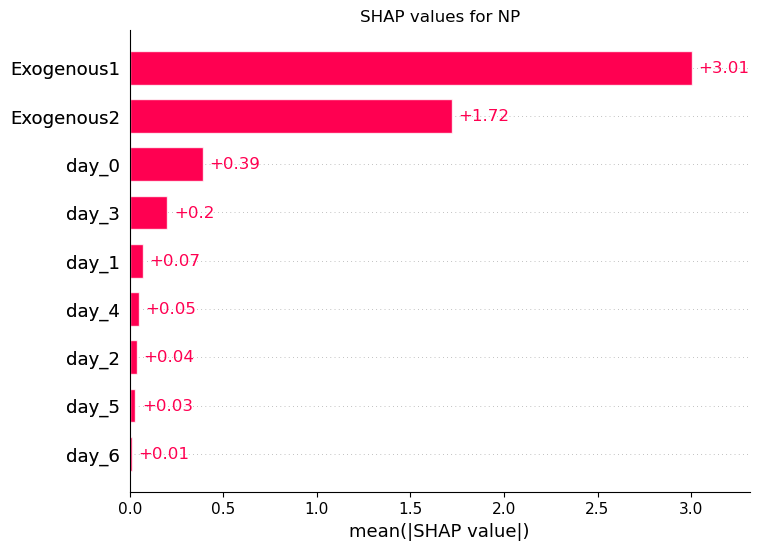

In [ ]:
import shap
import matplotlib.pyplot as plt

shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = shap_df[shap_columns].values  # SHAP values matrix
base_values = shap_df['base_value'].values  # Extract base values
features = shap_columns  # Feature names

# Create a SHAP values object
shap_obj = shap.Explanation(values=shap_values, base_values=base_values, feature_names=features)

# Plot the bar plot for SHAP values
shap.plots.bar(shap_obj, max_display=len(features), show=False)
plt.title(f'SHAP values for NP')
plt.show()

The plot above shows the average SHAP values for each feature across the entire horizon.

Here, we see that `Exogenous1` is the most important feature, as it has the largest average contribution. Remember that it designates the expected energy demand, so we can see that this variable has a large impact on the final prediction. On the other hand, `day_6` is the least imortant feature, since it has the lowest value.

Note that all values are positive, meaning that on average, every feature tends to increase the value of the predictions.

### 5.2 Waterfall plot

Now, let's see how we can make a waterfall plot to explore the the impact of features at a single prediction step. The code below selects a specific date. Of course, this can be modified for any series or date.

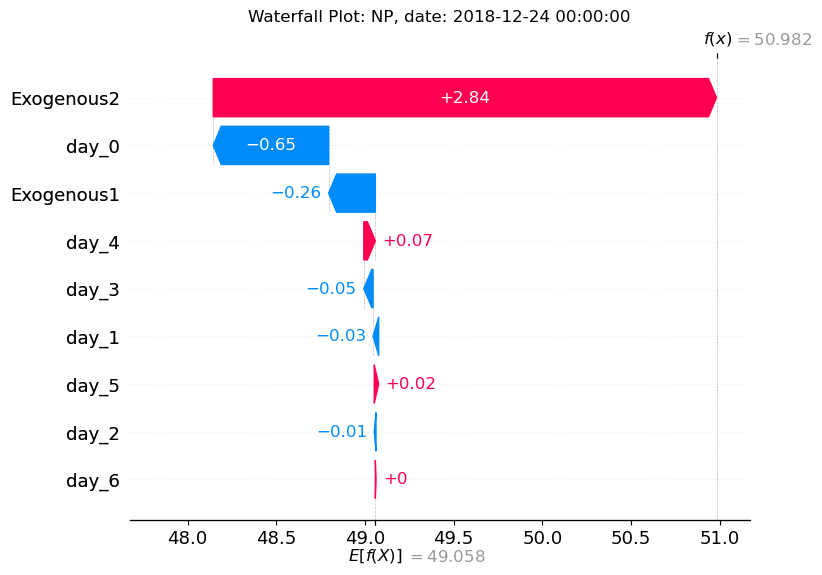

In [ ]:
#| eval: false
selected_ds = '2018-12-24 00:00:00'

filtered_df = shap_df[shap_df['ds'] == selected_ds]

shap_values = filtered_df[shap_columns].values.flatten()
base_value = filtered_df['base_value'].values[0]
features = shap_columns

shap_obj = shap.Explanation(values=shap_values, base_values=base_value, feature_names=features)

shap.plots.waterfall(shap_obj, show=False)
plt.title(f'Waterfall Plot: NP, date: {selected_ds}')
plt.show()

In the waterfall plot above, we can explore in more detail a single prediction. Here, we study the final prediction for the start of December 24th, 2018.

The x-axis represents the value of our series. At the bottom, we see `E[f(X)]` which represents the baseline value (the predicted value if exogenous features were unknown). 

Then, we see how each feature has impacted the final forecast. Features like `day_6`, `day_1`, `day_3`, `Exogenous1`, and `day_0` all push the forecast to the left (smaller value). On the other hand, `day_5`, `day_4` and `Exogenous2` push it to the right (larger value). 

At the top right, we see `f(x)` which is the final output of the model after considering the imapct of the exogenous features. Notice that this value corresponds to the final prediction from TimeGPT. Hence, we see that `Exogenous2` has a large positive value, which ultimately led to the final forecast being larger than the base value. This makes sense, because this variable is the expected energy production. If more energy is expected to be produced, it makes sense that the actual energy produced is larger.

### 5.3 Heatmap
We can also do a heatmap plot to see how each feature impacts the final prediction. Here, we only need to select a specific series.

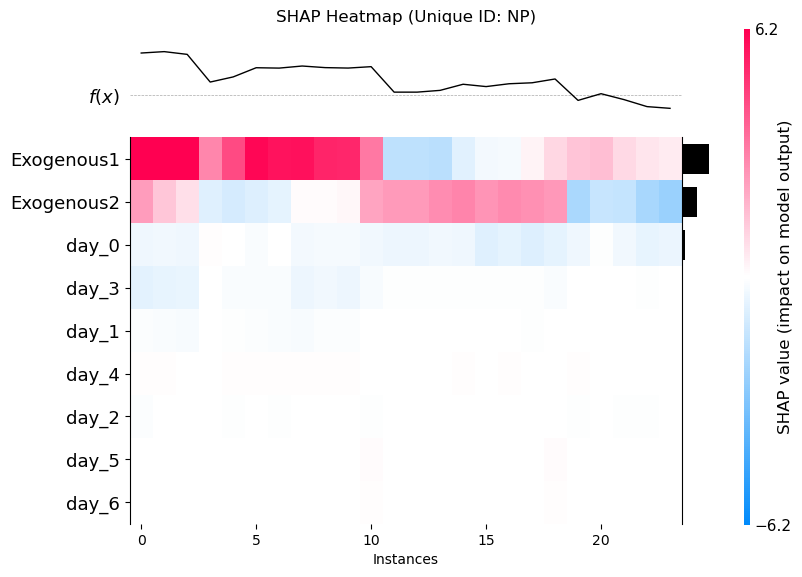

In [ ]:
shap_columns = shap_df.columns.difference(['unique_id', 'ds', 'TimeGPT', 'base_value'])
shap_values = shap_df[shap_columns].values  
feature_names = shap_columns.tolist()

shap_obj = shap.Explanation(values=shap_values, feature_names=feature_names)

shap.plots.heatmap(shap_obj, show=False)
plt.title(f'SHAP Heatmap (Unique ID: NP)')
plt.show()

With the heatmap, we basically see a breakdown of each each feature impacts the final predciton at each timestep.

On the x-axis, we have the number of instances, which corresponds to the number of prediction steps (24 in this case, since our horizon is set to 24h). On the y-axis, we have the name of the exogenous features.

First, notice that the ordering is the same as in the bar plot, where `Exogenous1` is the most important, and `day_6` is the least important.

Then, the color of the heatmap indiciates if the feature tends to increase of decrease the final prediction at each forecasting step. For example, `Exogenous1` tends to increase the predictions of the first 10h, but the impact is reversed afterwards.

We also see that `day_6`, `day_5`, `day_2`, `day_4` and `day_1` do not have a very large impact at any forecasting step, indicating that they barely impacting the final prediction.

Ultimately, the `feature_contributions` attribute gives you access to all the necessary information to explain the impact of exogenous features using the `shap` package.